Datasets used: 
- `adult (Adult)` :<br>The UCI Adult dataset contains 14 features, which can be divided into two categories: demographic and income-related.<br> The demographic features include:

    age: continuous.<br>
    fnlwgt : continuous, represents final weight, which is the number of units in the target population that the responding unit represents.<br>
    workclass: categorical, with values 'Private', 'Local-gov', 'Self-emp-not-inc', 'Federal-gov', 'State-gov', 'Self-emp-inc', 'Without-pay'.<br>
    education: categorical, with values '11th', 'HS-grad', 'Assoc-acdm', 'Some-college', '10th', ..., '9th', 'Doctorate', '12th', '1st-4th', 'Preschool'.<br>
    education-num: continuous with values 1 to 16, one number assigned to each label of education feature.<br>
    marital-status: categorical, with values 'Never-married', 'Married-civ-spouse', 'Widowed', 'Separated', 'Divorced', 'Married-spouse-absent', 'Married-AF-spouse'.<br>
    occupation: categorical, with values such as 'Machine-op-inspct', 'Farming-fishing', 'Protective-serv'.<br>
    relationship: categorical, with values 'Own-child', 'Husband', 'Not-in-family', 'Unmarried', 'Wife', 'Other-relative'.<br>
    race: categorical, with values such as white, black, and Asian.<br>
    sex: categorical, with values male and female.<br>
    
    The income-related features include:<br>

    hours-per-week: continuous.<br>
    native-country: categorical, with values such as United-States, Mexico, and Germany.<br>
    capital-gain: continuous, represent the amount of money an individual has gained from the sale of investments such as stocks, bonds, or real estate.<br>
    capital-loss: continuous, represent the amount of money an individual has lost from the sale of investments such as stocks, bonds, or real estate..<br>
    The target feature is the income, which is binary:<br>
    income: categorical, with values less than or equal to 50K and greater than 50K.<br>

Reference Links: https://archive.ics.uci.edu/ml/datasets/adult

In [1]:
import pandas as pd
import numpy as np
from pprint import pprint

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import gfacts
from gfacts.clean import clean_dataset
from gfacts import valid_ifthens_with_coverage_correctness, rules2rulesbyif
from gfacts.models import customLogisticRegression
from gfacts.parameters import ParameterProxy
from gfacts.formatting import recourse_report_reverse, print_recourse_report
import matplotlib.pyplot as plt

from IPython.display import Markdown, display

## Load Dataset

In [2]:
urlfile= "https://raw.githubusercontent.com/columbia/fairtest/master/data/adult/adult.csv"

X = pd.read_csv(urlfile)
df = clean_dataset(X, "adult")

age = [val.left for val in df.age.unique()]
age.sort()

df.head()

,age,Workclass,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,"(34.0, 41.0]",State-gov,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,FullTime,United-States,0
1,"(41.0, 50.0]",Self-emp-not-inc,13,Married-civ-spouse,Exec-managerial,Married,White,Male,0,0,PartTime,United-States,0
2,"(34.0, 41.0]",Private,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,FullTime,United-States,0
3,"(50.0, 90.0]",Private,7,Married-civ-spouse,Handlers-cleaners,Married,Black,Male,0,0,FullTime,United-States,0
4,"(26.0, 34.0]",Private,13,Married-civ-spouse,Prof-specialty,Married,Black,Female,0,0,FullTime,Cuba,0


## Model training and test

In [3]:
y = df['income']
X = df.drop('income', axis=1)

num_features = X._get_numeric_data().columns.to_list()
cate_features = X.select_dtypes(include=['object','category']).columns.to_list()

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=None, stratify=y)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [4]:
%%time

model = customLogisticRegression(max_iter = 1500)
model.fit(X_train, y_train, cate_columns=cate_features, target_column='income')
model.predict(X_test.iloc[:100, :])

Wall time: 7.31 s


array([0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [5]:
positive_label = 1
negative_label = 0
preds_Xtest = model.predict(X_test)
print(classification_report(y_test.map({negative_label: 0, positive_label: 1}), preds_Xtest))

              precision    recall  f1-score   support

           0       0.88      0.93      0.90     10205
           1       0.75      0.61      0.67      3362

    accuracy                           0.85     13567
   macro avg       0.81      0.77      0.79     13567
weighted avg       0.85      0.85      0.85     13567



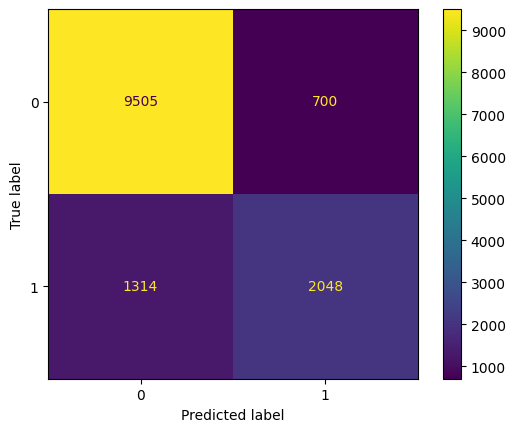

In [6]:
conf_matrix = confusion_matrix(y_test, preds_Xtest)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
cm_disp.plot()
plt.show()

## Find all valid if-thens with all respective coverages and correctness, for all subgroups.

**Caution!** This step takes time. Uncomment the following block if you wish to run.

In [7]:
# #Uncomment if you want to find new rules with different support

# ifthens_coverage_correctness = valid_ifthens_with_coverage_correctness(
#     X_test,
#     model=model,
#     sensitive_attribute='sex',
#     freqitem_minsupp = 0.03,
#     missing_subgroup_val="Unknown",
#     drop_infeasible = True,
#     drop_above = True
# )

# print(f"Number of if-thens: {len(ifthens_coverage_correctness)}")
# rules_by_if = rules2rulesbyif(ifthens_coverage_correctness)

In [8]:
from gfacts.utils import load_rules_by_if, save_rules_by_if

## Use this for loading rules from disk
rules_by_if = load_rules_by_if("rulesAdultFairTest_preproc.data")

## Use this for saving rules on disk
#save_rules_by_if("rulesAdultFairTest_preproc.data", rules_by_if)

In [9]:
# # run this section if you load data from disk that are computed with drop_infeasible,drop_above flags as False

# from gfacts.predicate import drop_two_above
# ifthens = gfacts.rulesbyif2rules(rules_by_if)
# ifthens = [(ifs,then,cov,cor) for ifs,then,cov,cor in ifthens if gfacts.recIsValid(ifs,then,X_test,True)]
# ifthens = [(ifs,then,cov,cor) for ifs,then,cov,cor in ifthens if drop_two_above(ifs,then,age)]
# rules_by_if = gfacts.rules2rulesbyif(ifthens)

In [10]:
K = 10

# keep K ifs with maximum coverage on Females
# TODO: the below is currently dataset dependent
# rules_by_if_filtered = sorted(rules_by_if.items(), key=lambda e: e[1]["F"][0][1], reverse=True)[:K]

# keep K ifs with maximum absolute difference in correctness between Males and Females.
# TODO: the below is currently dataset dependent
rules_by_if_filtered = sorted(rules_by_if.items(), key=lambda e: abs(e[1][" Male"][1][0][1]-e[1][" Female"][1][0][1]), reverse=True)[:K]

rules_by_if_filtered = dict(rules_by_if_filtered)

print(recourse_report_reverse(rules_by_if_filtered))

If capital-gain = 0, education-num = 9, occupation =  Sales, race =  White:
	Protected Subgroup ' Female', 3.57% covered
		Make education-num = 10, occupation =  Exec-managerial with correctness 4.83%.
	Protected Subgroup ' Male', 3.01% covered
		Make education-num = 10, occupation =  Exec-managerial with correctness 39.60%.
If education-num = 9, occupation =  Sales, race =  White:
	Protected Subgroup ' Female', 3.67% covered
		Make education-num = 10, occupation =  Exec-managerial with correctness 4.70%.
		Make occupation =  Exec-managerial with correctness 2.68%.
	Protected Subgroup ' Male', 3.12% covered
		Make education-num = 10, occupation =  Exec-managerial with correctness 38.28%.
		Make occupation =  Exec-managerial with correctness 22.97%.
If capital-loss = 0, education-num = 9, occupation =  Sales, race =  White:
	Protected Subgroup ' Female', 3.62% covered
		Make education-num = 10, occupation =  Exec-managerial with correctness 4.76%.
		Make occupation =  Exec-managerial wi

# Filter rules by different fairness definitions

Here, we explore more sophisticated ways of picking the "top" K rules and showing only those.

We start ranking the rule "groups" (all recourses for a single "if") by averaging out the costs of all suggested recourses, weighted by the respective correctness. For now, the "cost" of a recourse is simply the number of features whose value changes (and the magnitude of the change for numerical features, but here there are none).

In [11]:
feature_weights = {"sex": 1, "age": 1, "relationship": 10, "education-num": 20}
features_with_binary_cost = cate_features
features_with_proportional_cost = num_features


comparators = gfacts.feature_change_builder(
    X_test,
    num_cols=features_with_proportional_cost,
    cate_cols=features_with_binary_cost,
    feature_weights=feature_weights,
    num_normalization=True
)
params = ParameterProxy(featureChanges=comparators)

## Weighted Average Score

If capital-gain = 0, capital-loss = 0, native-country =  United-States, race =  White:
	Protected Subgroup ' Female', 71.11% covered out of 4081
		Make capital-gain = 15024 with correctness 71.28%.
		Make capital-gain = 7688 with correctness 25.99%.
		Make capital-gain = 7298 with correctness 23.53%.
		Aggregate cost of the above recourses = -3.78
	Protected Subgroup ' Male', 76.46% covered out of 6738
		Make capital-gain = 15024 with correctness 82.05%.
		Make capital-gain = 7688 with correctness 54.44%.
		Make capital-gain = 7298 with correctness 52.88%.
		Aggregate cost of the above recourses = -6.60
	Bias against  Female. Unfairness measure = 2.81.
	Cumulative correctness plot for the above recourses:


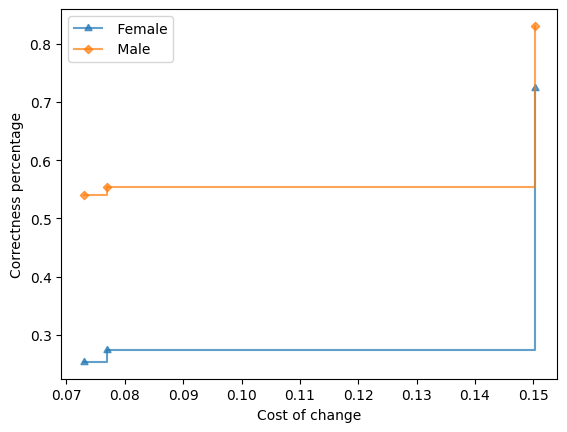

If capital-gain = 0, capital-loss = 0, education-num = 10, occupation =  Sales, race =  White:
	Protected Subgroup ' Female', 3.44% covered out of 4081
		Make occupation =  Exec-managerial with correctness 2.86%.
		Aggregate cost of the above recourses = -0.03
	Protected Subgroup ' Male', 3.09% covered out of 6738
		Make occupation =  Exec-managerial with correctness 27.54%.
		Aggregate cost of the above recourses = -0.28
	Bias against  Female. Unfairness measure = 0.25.
	Cumulative correctness plot for the above recourses:


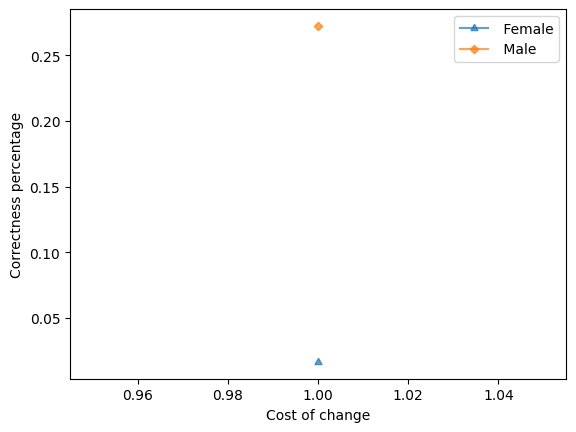

If education-num = 9, occupation =  Sales, race =  White:
	Protected Subgroup ' Female', 3.67% covered out of 4081
		Make education-num = 10, occupation =  Exec-managerial with correctness 4.70%.
		Make occupation =  Exec-managerial with correctness 2.68%.
		Aggregate cost of the above recourses = -0.02
	Protected Subgroup ' Male', 3.12% covered out of 6738
		Make education-num = 10, occupation =  Exec-managerial with correctness 38.28%.
		Make occupation =  Exec-managerial with correctness 22.97%.
		Aggregate cost of the above recourses = -0.20
	Bias against  Female. Unfairness measure = 0.17.
	Cumulative correctness plot for the above recourses:


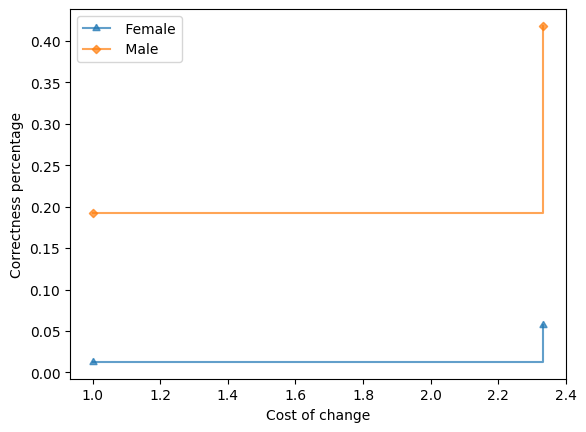

If Workclass =  Private, capital-gain = 0, capital-loss = 0, native-country =  United-States:
	Protected Subgroup ' Female', 68.36% covered out of 4081
		Make Workclass =  Self-emp-inc with correctness 0.65%.
		Make Workclass =  Local-gov with correctness 0.00%.
		Make Workclass =  Self-emp-not-inc with correctness 0.00%.
		Make Workclass =  Federal-gov with correctness 1.62%.
		Make capital-gain = 15024 with correctness 67.13%.
		Aggregate cost of the above recourses = -0.90
	Protected Subgroup ' Male', 64.03% covered out of 6738
		Make Workclass =  Self-emp-inc with correctness 5.17%.
		Make Workclass =  Local-gov with correctness 0.00%.
		Make Workclass =  Self-emp-not-inc with correctness 0.00%.
		Make Workclass =  Federal-gov with correctness 9.69%.
		Make capital-gain = 15024 with correctness 78.03%.
		Aggregate cost of the above recourses = -1.07
	Bias against  Female. Unfairness measure = 0.17.
	Cumulative correctness plot for the above recourses:


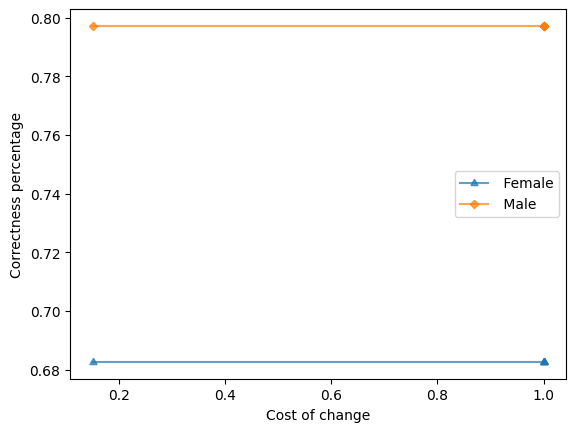

If capital-gain = 0, education-num = 9, occupation =  Sales:
	Protected Subgroup ' Female', 4.21% covered out of 4081
		Make education-num = 10, occupation =  Exec-managerial with correctness 4.09%.
		Make occupation =  Exec-managerial with correctness 2.34%.
		Aggregate cost of the above recourses = -0.02
	Protected Subgroup ' Male', 3.25% covered out of 6738
		Make education-num = 10, occupation =  Exec-managerial with correctness 37.16%.
		Make occupation =  Exec-managerial with correctness 22.02%.
		Aggregate cost of the above recourses = -0.19
	Bias against  Female. Unfairness measure = 0.17.
	Cumulative correctness plot for the above recourses:


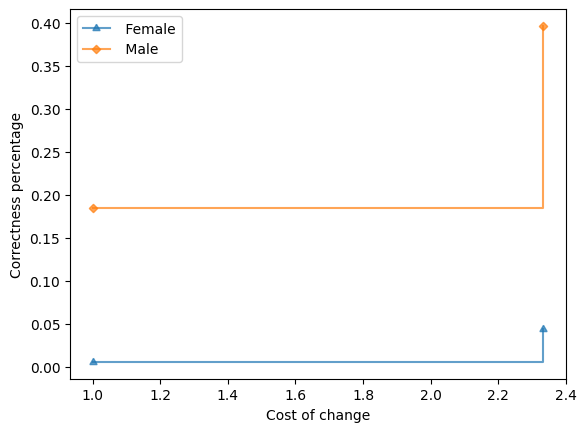

If capital-gain = 0, hours-per-week = FullTime, occupation =  Sales, race =  White:
	Protected Subgroup ' Female', 3.79% covered out of 4081
		Make hours-per-week = OverTime, occupation =  Exec-managerial with correctness 6.49%.
		Make occupation =  Exec-managerial with correctness 5.19%.
		Make hours-per-week = OverTime, occupation =  Prof-specialty with correctness 6.49%.
		Make occupation =  Prof-specialty with correctness 1.30%.
		Make hours-per-week = OverTime with correctness 1.30%.
		Make hours-per-week = BrainDrain, occupation =  Exec-managerial with correctness 8.44%.
		Make hours-per-week = BrainDrain, occupation =  Prof-specialty with correctness 6.49%.
		Aggregate cost of the above recourses = -0.03
	Protected Subgroup ' Male', 3.43% covered out of 6738
		Make hours-per-week = OverTime, occupation =  Exec-managerial with correctness 37.83%.
		Make occupation =  Exec-managerial with correctness 25.22%.
		Make hours-per-week = OverTime, occupation =  Prof-specialty with corre

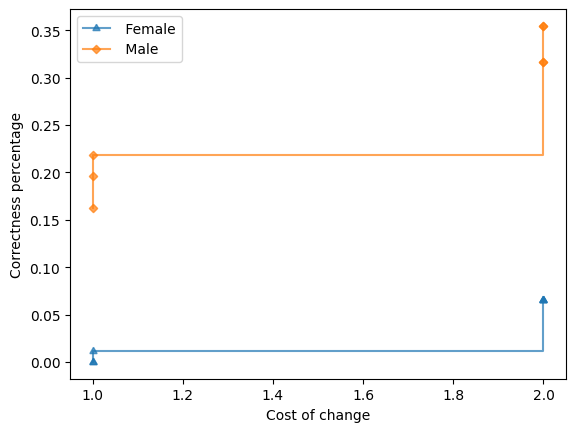

If Workclass =  Private, capital-gain = 0, capital-loss = 0, race =  White:
	Protected Subgroup ' Female', 60.58% covered out of 4081
		Make Workclass =  Self-emp-inc with correctness 0.73%.
		Make Workclass =  Local-gov with correctness 0.00%.
		Make Workclass =  Self-emp-not-inc with correctness 0.00%.
		Make Workclass =  Federal-gov with correctness 1.91%.
		Make capital-gain = 15024 with correctness 67.71%.
		Aggregate cost of the above recourses = -0.91
	Protected Subgroup ' Male', 62.51% covered out of 6738
		Make Workclass =  Self-emp-inc with correctness 5.23%.
		Make Workclass =  Local-gov with correctness 0.00%.
		Make Workclass =  Self-emp-not-inc with correctness 0.00%.
		Make Workclass =  Federal-gov with correctness 9.79%.
		Make capital-gain = 15024 with correctness 78.40%.
		Aggregate cost of the above recourses = -1.07
	Bias against  Female. Unfairness measure = 0.17.
	Cumulative correctness plot for the above recourses:


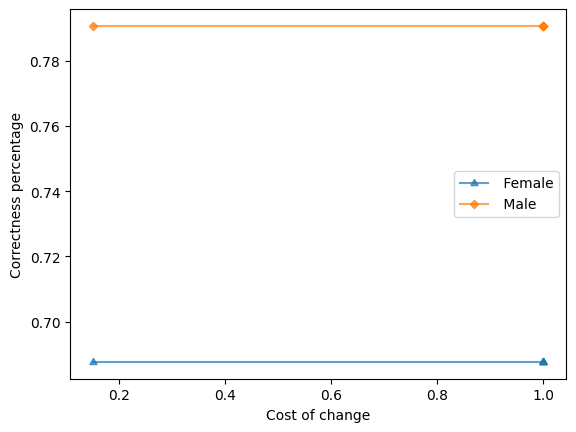

If Workclass =  Private, age = (50.0, 90.0], capital-gain = 0, hours-per-week = FullTime, native-country =  United-States, race =  White:
	Protected Subgroup ' Female', 4.18% covered out of 4081
		Make hours-per-week = OverTime with correctness 1.76%.
		Aggregate cost of the above recourses = -0.02
	Protected Subgroup ' Male', 4.88% covered out of 6738
		Make hours-per-week = OverTime with correctness 14.68%.
		Aggregate cost of the above recourses = -0.15
	Bias against  Female. Unfairness measure = 0.13.
	Cumulative correctness plot for the above recourses:


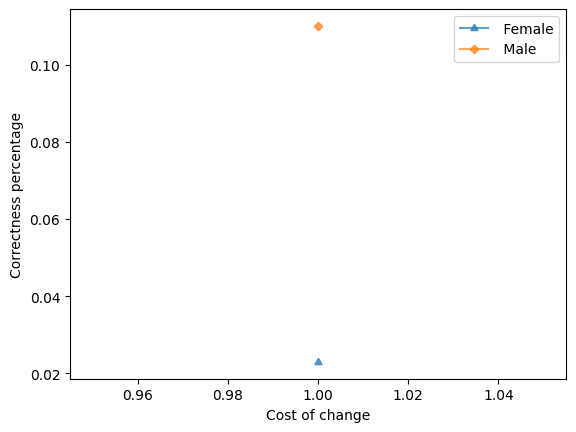

If capital-gain = 0, capital-loss = 0, hours-per-week = FullTime, occupation =  Adm-clerical:
	Protected Subgroup ' Female', 13.85% covered out of 4081
		Make hours-per-week = OverTime, occupation =  Exec-managerial with correctness 8.70%.
		Make occupation =  Exec-managerial with correctness 4.62%.
		Make occupation =  Prof-specialty with correctness 2.84%.
		Make hours-per-week = OverTime, occupation =  Prof-specialty with correctness 7.99%.
		Make hours-per-week = OverTime, occupation =  Sales with correctness 3.20%.
		Make hours-per-week = BrainDrain, occupation =  Exec-managerial with correctness 9.41%.
		Make hours-per-week = BrainDrain, occupation =  Prof-specialty with correctness 8.17%.
		Aggregate cost of the above recourses = -0.04
	Protected Subgroup ' Male', 3.55% covered out of 6738
		Make hours-per-week = OverTime, occupation =  Exec-managerial with correctness 32.35%.
		Make occupation =  Exec-managerial with correctness 21.85%.
		Make occupation =  Prof-specialty with 

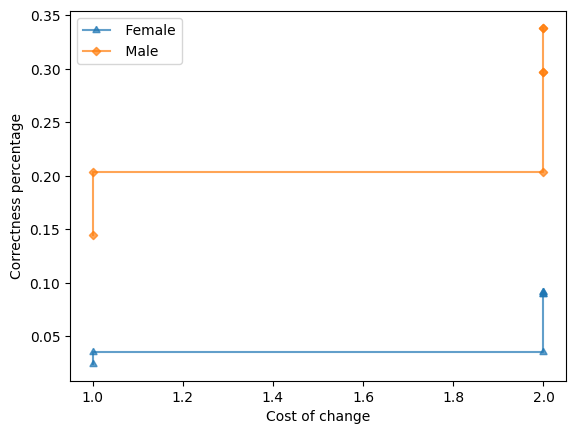

If education-num = 10, hours-per-week = FullTime, race =  White:
	Protected Subgroup ' Female', 9.01% covered out of 4081
		Make hours-per-week = OverTime with correctness 2.46%.
		Make hours-per-week = BrainDrain with correctness 3.28%.
		Aggregate cost of the above recourses = -0.03
	Protected Subgroup ' Male', 9.50% covered out of 6738
		Make hours-per-week = OverTime with correctness 12.40%.
		Make hours-per-week = BrainDrain with correctness 16.95%.
		Aggregate cost of the above recourses = -0.15
	Bias against  Female. Unfairness measure = 0.12.
	Cumulative correctness plot for the above recourses:


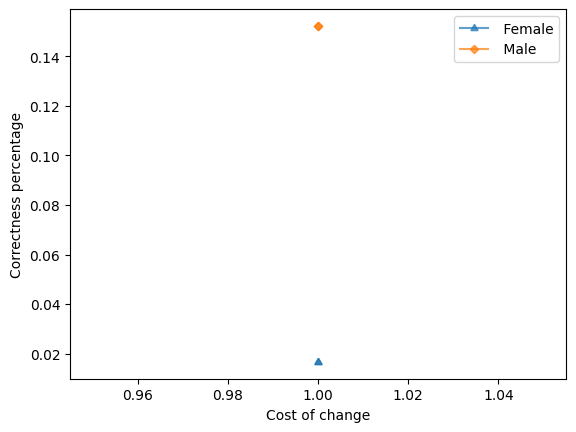

If capital-gain = 0, race =  Black:
	Protected Subgroup ' Female', 14.00% covered out of 4081
		Make race =  White with correctness 0.35%.
		Make capital-gain = 15024, race =  White with correctness 70.30%.
		Make capital-gain = 7688, race =  White with correctness 16.52%.
		Make capital-gain = 7298, race =  White with correctness 15.11%.
		Aggregate cost of the above recourses = -0.23
	Protected Subgroup ' Male', 7.82% covered out of 6738
		Make race =  White with correctness 2.86%.
		Make capital-gain = 15024, race =  White with correctness 75.00%.
		Make capital-gain = 7688, race =  White with correctness 38.55%.
		Make capital-gain = 7298, race =  White with correctness 36.64%.
		Aggregate cost of the above recourses = -0.35
	Bias against  Female. Unfairness measure = 0.12.
	Cumulative correctness plot for the above recourses:


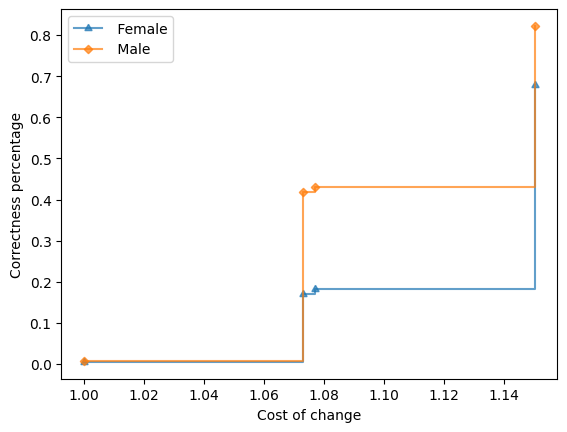

If Workclass =  Private, capital-gain = 0, capital-loss = 0, hours-per-week = FullTime, native-country =  United-States, occupation =  Machine-op-inspct:
	Protected Subgroup ' Female', 3.00% covered out of 4081
		Make hours-per-week = OverTime, occupation =  Exec-managerial with correctness 4.10%.
		Make occupation =  Exec-managerial with correctness 0.82%.
		Make hours-per-week = OverTime, occupation =  Prof-specialty with correctness 4.10%.
		Make occupation =  Prof-specialty with correctness 0.00%.
		Aggregate cost of the above recourses = -0.01
	Protected Subgroup ' Male', 5.40% covered out of 6738
		Make hours-per-week = OverTime, occupation =  Exec-managerial with correctness 31.49%.
		Make occupation =  Exec-managerial with correctness 15.19%.
		Make hours-per-week = OverTime, occupation =  Prof-specialty with correctness 30.94%.
		Make occupation =  Prof-specialty with correctness 5.52%.
		Aggregate cost of the above recourses = -0.13
	Bias against  Female. Unfairness measure =

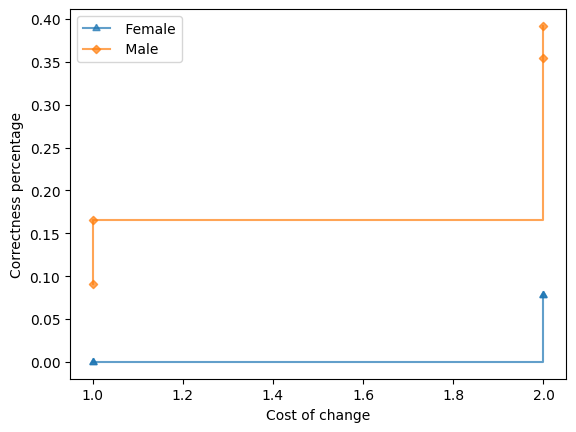

If Workclass =  Private, age = (26.0, 34.0], capital-loss = 0, education-num = 10:
	Protected Subgroup ' Female', 4.08% covered out of 4081
		Make age = (41.0, 50.0] with correctness 4.22%.
		Aggregate cost of the above recourses = -0.04
	Protected Subgroup ' Male', 4.16% covered out of 6738
		Make age = (41.0, 50.0] with correctness 15.77%.
		Aggregate cost of the above recourses = -0.16
	Bias against  Female. Unfairness measure = 0.12.
	Cumulative correctness plot for the above recourses:


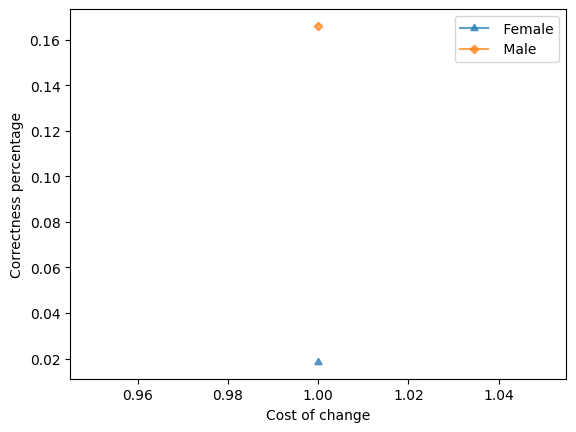

If education-num = 10, hours-per-week = FullTime, native-country =  United-States:
	Protected Subgroup ' Female', 11.22% covered out of 4081
		Make hours-per-week = OverTime with correctness 2.19%.
		Make hours-per-week = BrainDrain with correctness 2.85%.
		Aggregate cost of the above recourses = -0.03
	Protected Subgroup ' Male', 10.38% covered out of 6738
		Make hours-per-week = OverTime with correctness 11.93%.
		Make hours-per-week = BrainDrain with correctness 15.95%.
		Aggregate cost of the above recourses = -0.14
	Bias against  Female. Unfairness measure = 0.11.
	Cumulative correctness plot for the above recourses:


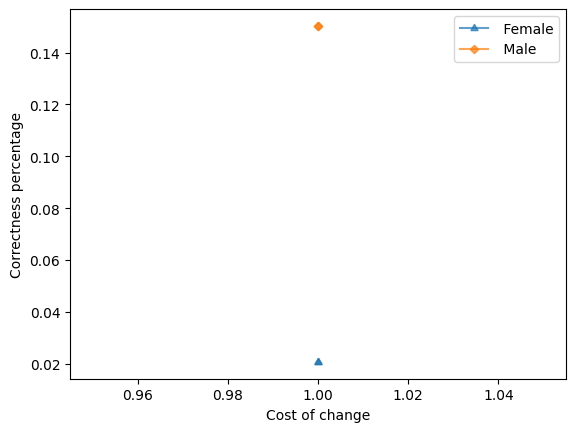

If Workclass =  Private, capital-gain = 0, capital-loss = 0, native-country =  United-States, occupation =  Machine-op-inspct, race =  White:
	Protected Subgroup ' Female', 3.20% covered out of 4081
		Make occupation =  Exec-managerial with correctness 0.77%.
		Make occupation =  Prof-specialty with correctness 0.00%.
		Make occupation =  Sales with correctness 0.00%.
		Aggregate cost of the above recourses = 0.00
	Protected Subgroup ' Male', 6.65% covered out of 6738
		Make occupation =  Exec-managerial with correctness 19.51%.
		Make occupation =  Prof-specialty with correctness 11.66%.
		Make occupation =  Sales with correctness 3.36%.
		Aggregate cost of the above recourses = -0.12
	Bias against  Female. Unfairness measure = 0.11.
	Cumulative correctness plot for the above recourses:


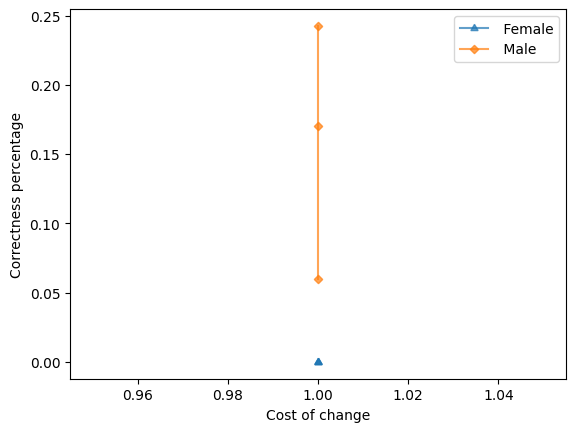

If age = (34.0, 41.0], capital-gain = 0, capital-loss = 0, education-num = 10, native-country =  United-States:
	Protected Subgroup ' Female', 3.25% covered out of 4081
		Make age = (41.0, 50.0] with correctness 1.52%.
		Aggregate cost of the above recourses = -0.02
	Protected Subgroup ' Male', 3.63% covered out of 6738
		Make age = (41.0, 50.0] with correctness 12.76%.
		Aggregate cost of the above recourses = -0.13
	Bias against  Female. Unfairness measure = 0.11.
	Cumulative correctness plot for the above recourses:


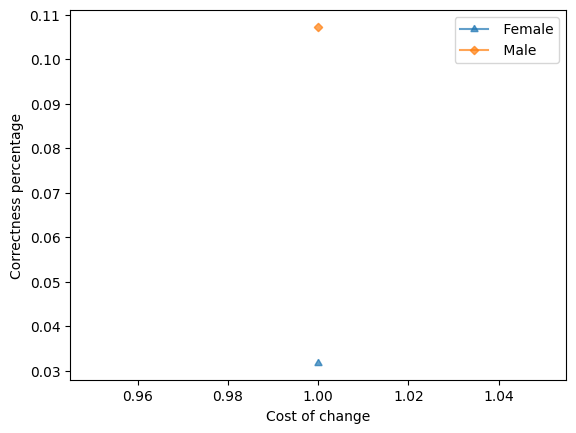

If age = (26.0, 34.0], capital-gain = 0, education-num = 10:
	Protected Subgroup ' Female', 4.92% covered out of 4081
		Make age = (41.0, 50.0] with correctness 3.50%.
		Aggregate cost of the above recourses = -0.04
	Protected Subgroup ' Male', 5.28% covered out of 6738
		Make age = (41.0, 50.0] with correctness 14.69%.
		Aggregate cost of the above recourses = -0.15
	Bias against  Female. Unfairness measure = 0.11.
	Cumulative correctness plot for the above recourses:


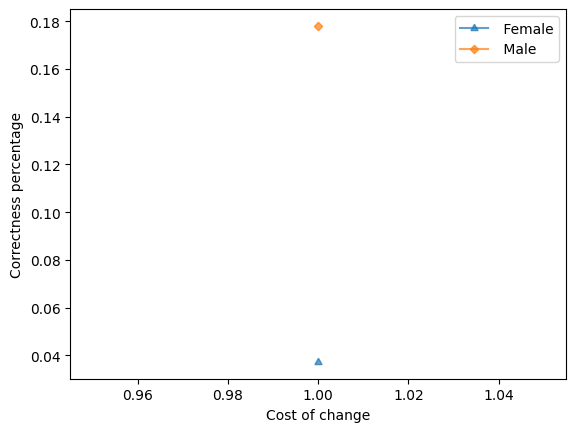

If capital-gain = 0, capital-loss = 0, native-country =  United-States, occupation =  Adm-clerical, race =  White:
	Protected Subgroup ' Female', 19.49% covered out of 4081
		Make occupation =  Exec-managerial with correctness 3.41%.
		Make occupation =  Prof-specialty with correctness 2.15%.
		Make occupation =  Sales with correctness 0.13%.
		Aggregate cost of the above recourses = -0.02
	Protected Subgroup ' Male', 4.57% covered out of 6738
		Make occupation =  Exec-managerial with correctness 18.30%.
		Make occupation =  Prof-specialty with correctness 14.38%.
		Make occupation =  Sales with correctness 4.58%.
		Aggregate cost of the above recourses = -0.12
	Bias against  Female. Unfairness measure = 0.11.
	Cumulative correctness plot for the above recourses:


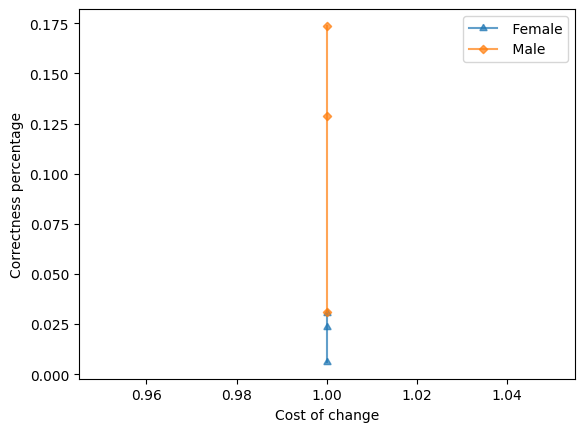

If hours-per-week = FullTime, occupation =  Adm-clerical, race =  White:
	Protected Subgroup ' Female', 11.17% covered out of 4081
		Make hours-per-week = OverTime, occupation =  Exec-managerial with correctness 9.25%.
		Make hours-per-week = OverTime, occupation =  Prof-specialty with correctness 8.81%.
		Make occupation =  Exec-managerial with correctness 5.51%.
		Make occupation =  Prof-specialty with correctness 3.52%.
		Make hours-per-week = OverTime, occupation =  Sales with correctness 3.96%.
		Make hours-per-week = BrainDrain, occupation =  Exec-managerial with correctness 9.91%.
		Make hours-per-week = BrainDrain, occupation =  Prof-specialty with correctness 9.03%.
		Make occupation =  Sales with correctness 0.44%.
		Make occupation =  Craft-repair with correctness 0.00%.
		Aggregate cost of the above recourses = -0.03
	Protected Subgroup ' Male', 3.03% covered out of 6738
		Make hours-per-week = OverTime, occupation =  Exec-managerial with correctness 33.50%.
		Make hours-pe

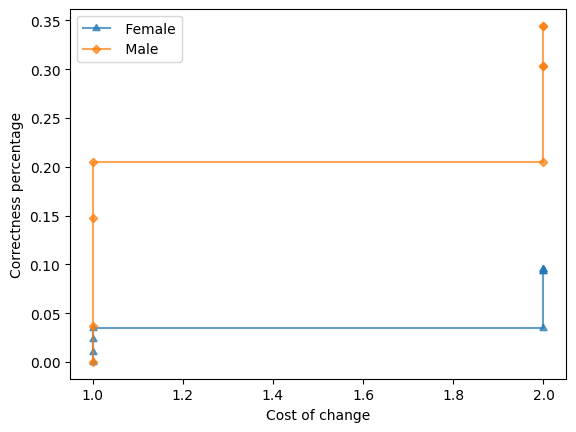

In [12]:
top_rules, subgroup_costs = gfacts.select_rules_subset(
    rules_by_if,
    metric = "weighted-average",
    sort_strategy = "abs-diff-decr",
    top_count = 200,
    filter_sequence = [
        "remove-contained",
        # "remove-fair-rules",
    ],
    cor_threshold=None,
    secondary_sorting_objectives=[
        # "min-group-cost",
        # "max-group-corr"
    ],
    params=params
)

cum_cors = gfacts.cumcorr_all(top_rules, X_test, model, sensitive_attribute="sex", params=params)

pop_sizes = {sg: ((X_test["sex"] == sg) & (preds_Xtest == 0)).sum() for sg in X_test["sex"].unique()}
print_recourse_report(
    top_rules,
    population_sizes=pop_sizes,
    subgroup_costs=subgroup_costs,
    aggregate_cors_costs=cum_cors,
    show_subgroup_costs=True
)

## Minimum cost above threshold

In [13]:
top_rules, subgroup_costs = gfacts.select_rules_subset(
    rules_by_if,
    metric="min-above-thr",
    sort_strategy="generic-sorting-ignore-exists-subgroup-empty",
    top_count=50,
    filter_sequence = [
        "remove-contained",
        "remove-below-thr",        
        "remove-fair-rules",
        "keep-only-min-change"
    ],
    cor_threshold=0.5,
    secondary_sorting_objectives=[
        # "min-group-cost",
        "max-group-corr"
    ],
    params=params
)

#cum_cors = gfacts.cumcorr_all(top_rules, X_test, model, sensitive_attribute="sex", params=params)
cum_cors = dict()

pop_sizes = {sg: ((X_test["sex"] == sg) & (preds_Xtest == 0)).sum() for sg in X_test["sex"].unique()}
print_recourse_report(
    top_rules,
    population_sizes=pop_sizes,
    subgroup_costs=subgroup_costs,
    aggregate_cors_costs=cum_cors,
    show_subgroup_costs=True
)

If education-num = 13, marital-status =  Never-married, relationship =  Not-in-family:
	Protected Subgroup ' Female', 5.86% covered out of 4081
		Make marital-status =  Married-civ-spouse, relationship =  Married with correctness 50.84%.
		Aggregate cost of the above recourses = 11.00
	Protected Subgroup ' Male', 3.71% covered out of 6738
		Make education-num = 14, marital-status =  Married-civ-spouse, relationship =  Married with correctness 55.82%.
		Aggregate cost of the above recourses = 12.33
	Bias against  Male. Unfairness measure = 1.33.
If Workclass =  Private, age = (26.0, 34.0], marital-status =  Never-married, relationship =  Not-in-family:
	Protected Subgroup ' Female', 5.27% covered out of 4081
		Make age = (41.0, 50.0], marital-status =  Married-civ-spouse, relationship =  Married with correctness 59.81%.
		Aggregate cost of the above recourses = 12.00
	Protected Subgroup ' Male', 4.33% covered out of 6738
		Make Workclass =  Self-emp-inc, age = (41.0, 50.0], marital-stat

## Mean cost above threshold

In [17]:
top_rules, subgroup_costs = gfacts.select_rules_subset(
    rules_by_if,
    metric="mean-above-thr",
    sort_strategy="generic-sorting-ignore-forall-subgroups-empty",
    top_count=50,
    filter_sequence = [
        "remove-contained",
        "remove-below-thr",
        "remove-fair-rules",
        # "keep-only-min-change"
    ],
    cor_threshold=0.2,
    secondary_sorting_objectives=[
        # "min-group-cost",
        # "max-group-corr"
    ],
    params=params
)

# cum_cors = gfacts.cumcorr_all(top_rules, X_test, model, sensitive_attribute="sex", params=params)
cum_cors = dict()

pop_sizes = {sg: ((X_test["sex"] == sg) & (preds_Xtest == 0)).sum() for sg in X_test["sex"].unique()}
print_recourse_report(
    top_rules,
    population_sizes=pop_sizes,
    subgroup_costs=subgroup_costs,
    aggregate_cors_costs=cum_cors,
    show_subgroup_costs=True
)

If Workclass =  Private, occupation =  Adm-clerical:
	Protected Subgroup ' Female', 20.05% covered out of 4081
		No recourses for this subgroup!
		Aggregate cost of the above recourses = inf
	Protected Subgroup ' Male', 4.74% covered out of 6738
		Make Workclass =  Self-emp-inc, occupation =  Exec-managerial with correctness 22.64%.
		Aggregate cost of the above recourses = 2.00
	Bias against  Female. Unfairness measure = inf.
If hours-per-week = FullTime, occupation =  Adm-clerical:
	Protected Subgroup ' Female', 14.49% covered out of 4081
		No recourses for this subgroup!
		Aggregate cost of the above recourses = inf
	Protected Subgroup ' Male', 3.76% covered out of 6738
		Make hours-per-week = OverTime, occupation =  Exec-managerial with correctness 32.54%.
		Make occupation =  Exec-managerial with correctness 21.83%.
		Make hours-per-week = OverTime, occupation =  Prof-specialty with correctness 31.75%.
		Make hours-per-week = BrainDrain, occupation =  Exec-managerial with correctn

## Number above threshold

In [16]:
top_rules, subgroup_costs = gfacts.select_rules_subset(
    rules_by_if,
    metric="num-above-thr",
    sort_strategy="generic-sorting-ignore-forall-subgroups-empty",
    top_count=50,
    filter_sequence = [
        "remove-contained",
        "remove-below-thr",
        # "remove-fair-rules"
    ],
    cor_threshold=0.2,
    secondary_sorting_objectives=[
        # "min-group-cost",
        # "max-group-corr"
    ],
    params=params
)

# cum_cors = gfacts.cumcorr_all(top_rules, X_test, model, sensitive_attribute="sex", params=params)
cum_cors = dict()

pop_sizes = {sg: ((X_test["sex"] == sg) & (preds_Xtest == 0)).sum() for sg in X_test["sex"].unique()}
print_recourse_report(
    top_rules,
    population_sizes=pop_sizes,
    subgroup_costs=subgroup_costs,
    aggregate_cors_costs=cum_cors,
    show_subgroup_costs=True
)

If hours-per-week = FullTime, occupation =  Adm-clerical:
	Protected Subgroup ' Female', 14.49% covered out of 4081
		No recourses for this subgroup!
		Aggregate cost of the above recourses = 0.00
	Protected Subgroup ' Male', 3.76% covered out of 6738
		Make hours-per-week = OverTime, occupation =  Exec-managerial with correctness 32.54%.
		Make occupation =  Exec-managerial with correctness 21.83%.
		Make hours-per-week = OverTime, occupation =  Prof-specialty with correctness 31.75%.
		Make hours-per-week = BrainDrain, occupation =  Exec-managerial with correctness 34.13%.
		Make hours-per-week = BrainDrain, occupation =  Prof-specialty with correctness 32.14%.
		Aggregate cost of the above recourses = -5.00
	Bias against  Female. Unfairness measure = 5.
If hours-per-week = FullTime, occupation =  Sales:
	Protected Subgroup ' Female', 4.58% covered out of 4081
		No recourses for this subgroup!
		Aggregate cost of the above recourses = 0.00
	Protected Subgroup ' Male', 3.94% covered o